In [1]:
import pandas as pd
import numpy as np

import pymc as pm
import arviz as az

from scipy.stats import poisson

from matplotlib import pyplot as plt

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
teams = pd.read_csv('data/teams.csv').convert_dtypes()
results = pd.read_csv('data/results.csv').convert_dtypes()
fixtures = pd.read_csv('data/fixtures.csv').convert_dtypes()

In [3]:
# For this case need to create a team ID map from 0 to 27, instead of 1 to 28 for tensor calculation
# Create a mapping from team IDs to consecutive integers
team_id_map = {team_id: i for i, team_id in enumerate(teams['TeamID'].unique())}
results['HomeTeamIdx'] = results['HomeTeamID'].map(team_id_map)
results['AwayTeamIdx'] = results['AwayTeamID'].map(team_id_map)
fixtures['HomeTeamIdx'] = fixtures['HomeTeamID'].map(team_id_map)
fixtures['AwayTeamIdx'] = fixtures['AwayTeamID'].map(team_id_map)

# Calculate total goals scored and conceded by each team in home and away matches
team_stats_home = results.groupby('HomeTeamIdx').agg({'HomeScore': 'sum', 'AwayScore': 'sum', 'HomeTeamIdx': 'count'}).rename(columns={'HomeScore': 'home_goals_scored', 'AwayScore': 'home_goals_conceded', 'HomeTeamIdx': 'home_games_played'}).reset_index()
team_stats_away = results.groupby('AwayTeamIdx').agg({'HomeScore': 'sum', 'AwayScore': 'sum', 'AwayTeamIdx': 'count'}).rename(columns={'HomeScore': 'away_goals_conceded', 'AwayScore': 'away_goals_scored', 'AwayTeamIdx': 'away_games_played'}).reset_index()

# Merge home and away stats
team_stats = pd.merge(team_stats_home, team_stats_away, left_on='HomeTeamIdx', right_on='AwayTeamIdx')

# Calculate league averages and standard deviations aggregated by HomeTeamIdx and AwayTeamIdx
league_avg_home_goals = team_stats['home_goals_scored'].mean()
league_avg_away_goals = team_stats['away_goals_scored'].mean()
league_std_home_goals = team_stats['home_goals_scored'].std()
league_std_away_goals = team_stats['away_goals_scored'].std()

# Convert team indices to numpy arrays
home_team_ids = results['HomeTeamIdx'].values
away_team_ids = results['AwayTeamIdx'].values

In [4]:
# Define the PyMC model
with pm.Model() as model:
  
    # Hyperpriors for the Gamma distribution of team strengths
    alpha_home_scored = (league_avg_home_goals / league_std_home_goals) ** 2
    beta_home_scored = league_avg_home_goals / (league_std_home_goals ** 2)
    
    alpha_away_scored = (league_avg_away_goals / league_std_away_goals) ** 2
    beta_away_scored = league_avg_away_goals / (league_std_away_goals ** 2)
    
    alpha_home_conceded = (league_avg_away_goals / league_std_away_goals) ** 2
    beta_home_conceded = league_avg_away_goals / (league_std_away_goals ** 2)
    
    alpha_away_conceded = (league_avg_home_goals / league_std_home_goals) ** 2
    beta_away_conceded = league_avg_home_goals / (league_std_home_goals ** 2)
    
    # Priors for team strengths
    home_scoring_strength = pm.Gamma('home_scoring_strength', alpha_home_scored, beta_home_scored, shape=len(teams))
    away_scoring_strength = pm.Gamma('away_scoring_strength', alpha_away_scored, beta_away_scored, shape=len(teams))
    home_defensive_strength = pm.Gamma('home_defensive_strength', alpha_home_conceded, beta_home_conceded, shape=len(teams))
    away_defensive_strength = pm.Gamma('away_defensive_strength', alpha_away_conceded, beta_away_conceded, shape=len(teams))
    
    # Likelihood for observed goals
    home_goals = pm.Poisson('home_goals', mu=home_scoring_strength[home_team_ids] * away_defensive_strength[away_team_ids], observed=results['HomeScore'].values)
    away_goals = pm.Poisson('away_goals', mu=away_scoring_strength[away_team_ids] * home_defensive_strength[home_team_ids], observed=results['AwayScore'].values)
    

    # Sample from the posterior
    trace = pm.sample(4000, tune=4000, chains=4, cores=4, init='jitter+adapt_diag', return_inferencedata=True)
  

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [home_scoring_strength, away_scoring_strength, home_defensive_strength, away_defensive_strength]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Output()

Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 249 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


`Note:` Since there is some warning, lets check the trace validation. In principal we can use more sampling, tunes and chains to improve the convergence BUT I am limited by my local resources 

In [5]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

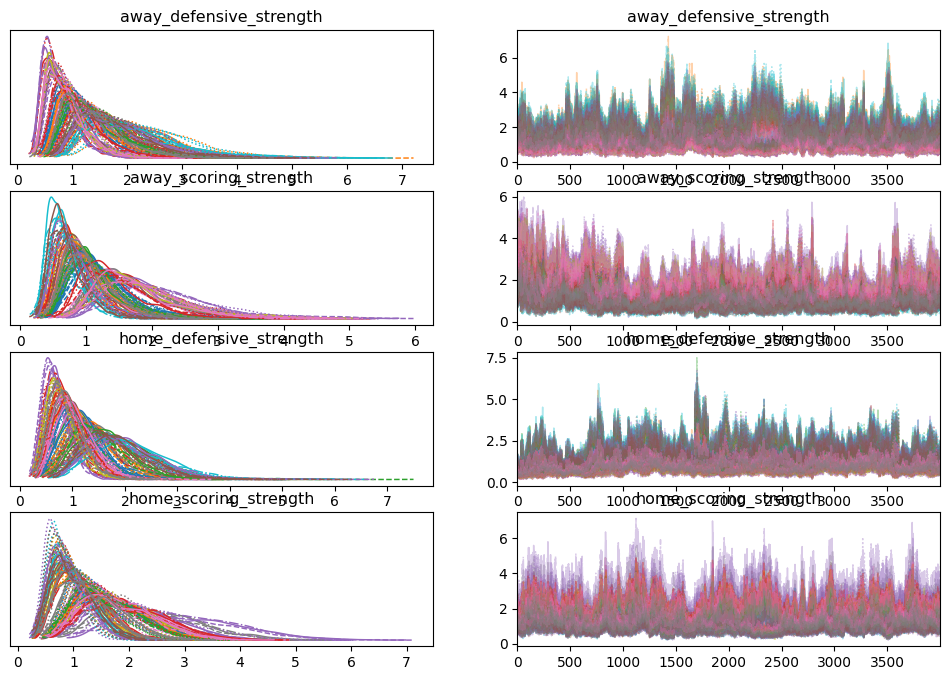

/Users/ahasib/Library/Caches/pypoetry/virtualenvs/pythia-soccer-BGTKE3L9-py3.10/lib/python3.10/site-packages/arviz/plots/plot_utils.py:272: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (448) in plot_autocorr, generating only 40 plots
  warnings.warn(


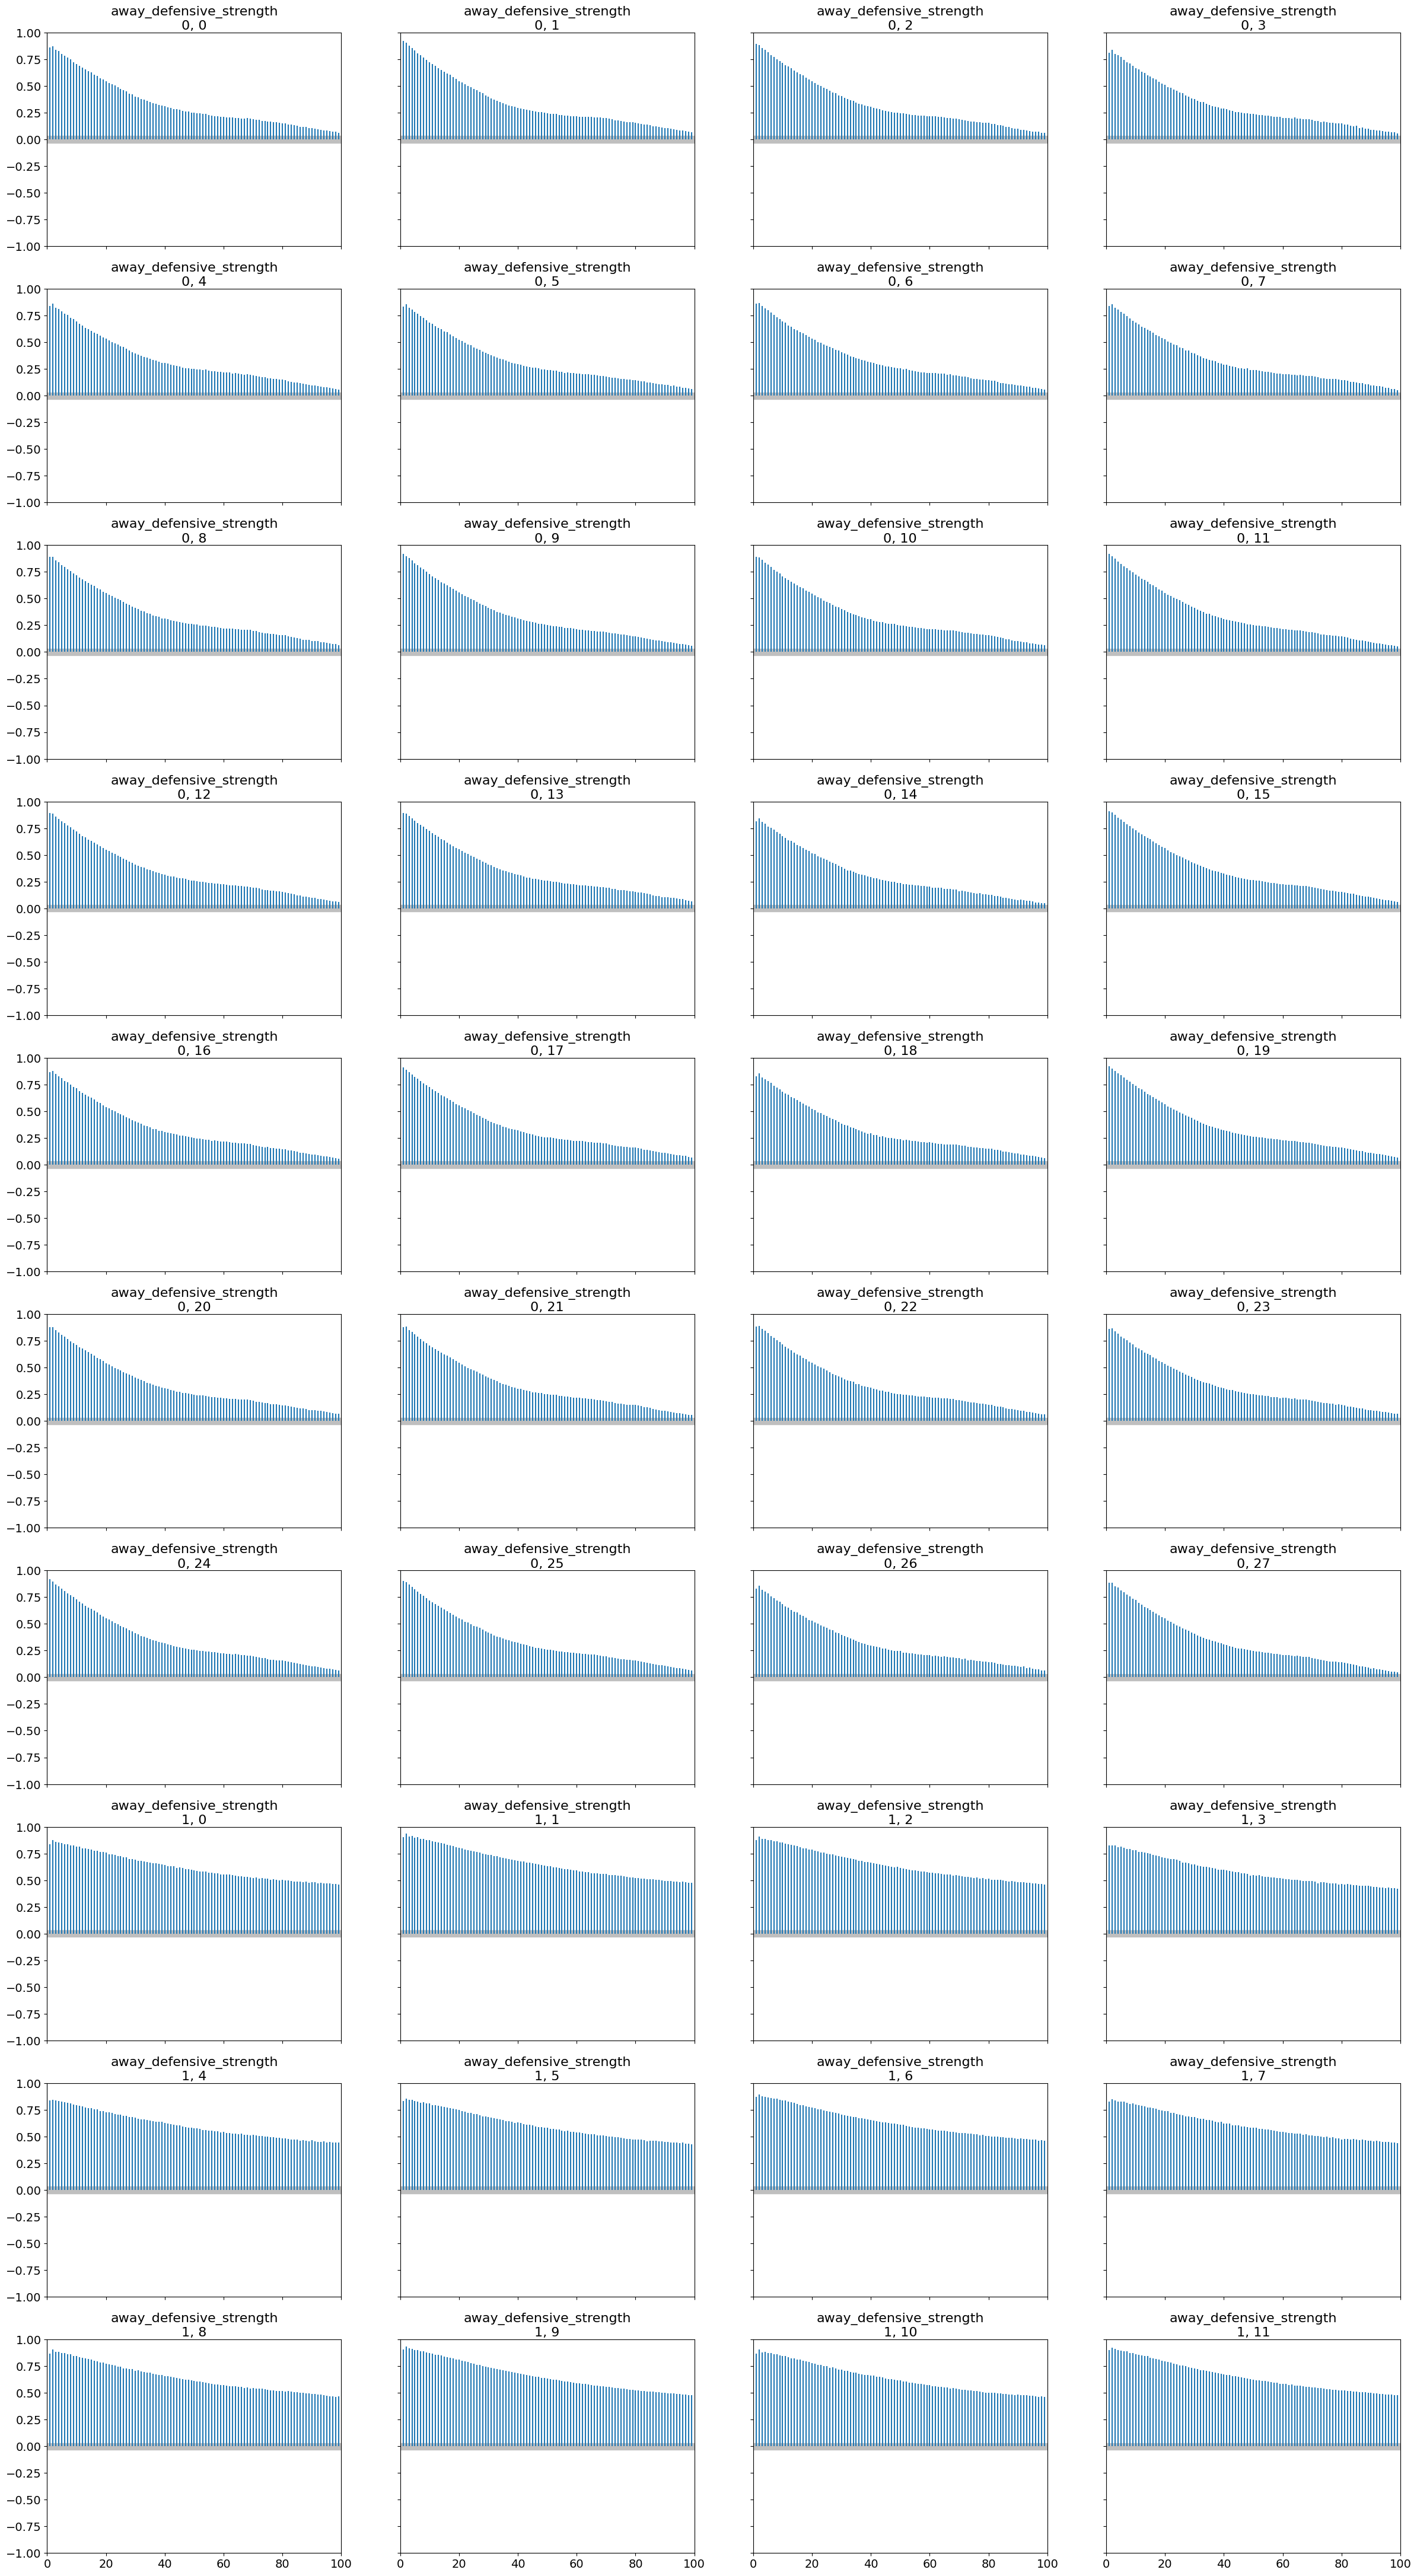

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
away_defensive_strength[0],1.188,0.465,0.484,2.056,0.076,0.055,40.0,146.0,1.10
away_defensive_strength[1],2.217,0.849,0.928,3.776,0.140,0.100,40.0,129.0,1.10
away_defensive_strength[2],1.618,0.624,0.672,2.776,0.103,0.073,40.0,139.0,1.10
away_defensive_strength[3],0.789,0.316,0.318,1.380,0.051,0.036,41.0,152.0,1.09
away_defensive_strength[4],0.982,0.388,0.398,1.707,0.062,0.044,42.0,144.0,1.09
...,...,...,...,...,...,...,...,...,...
home_scoring_strength[23],1.854,0.674,0.766,3.108,0.101,0.072,41.0,128.0,1.10
home_scoring_strength[24],0.857,0.325,0.335,1.462,0.046,0.033,43.0,159.0,1.09
home_scoring_strength[25],0.915,0.345,0.354,1.563,0.050,0.036,43.0,157.0,1.09
home_scoring_strength[26],1.714,0.626,0.692,2.886,0.094,0.067,41.0,133.0,1.10


In [6]:
# Check the trace validation 

# Trace plots
az.plot_trace(trace)
plt.show()

# Autocorrelation plots
az.plot_autocorr(trace)
plt.show()

# Summary statistics including R-hat and ESS
summary = az.summary(trace)
display(summary)


`Validation:`
* well mixed trace plots 
* Low correlation 
* r_hat show convergence can be improved 
* ess values can be improved 

Due to lack of computing resources I will proceed with this trace 

In [7]:

# Extract the posterior mean values for the parameters
home_scoring_strength_mean = trace.posterior['home_scoring_strength'].mean(dim=['chain', 'draw']).values
away_scoring_strength_mean = trace.posterior['away_scoring_strength'].mean(dim=['chain', 'draw']).values
home_defensive_strength_mean = trace.posterior['home_defensive_strength'].mean(dim=['chain', 'draw']).values
away_defensive_strength_mean = trace.posterior['away_defensive_strength'].mean(dim=['chain', 'draw']).values

# Predict goals for fixtures using the mean values
home_team_ids = fixtures['HomeTeamIdx'].values
away_team_ids = fixtures['AwayTeamIdx'].values

predicted_home_goals = np.zeros(len(fixtures))
predicted_away_goals = np.zeros(len(fixtures))

for i in range(len(fixtures)):
    home_team_idx = home_team_ids[i]
    away_team_idx = away_team_ids[i]
    
    home_strength = home_scoring_strength_mean[home_team_idx]
    away_defense = away_defensive_strength_mean[away_team_idx]
    away_strength = away_scoring_strength_mean[away_team_idx]
    home_defense = home_defensive_strength_mean[home_team_idx]
    
    predicted_home_goals[i] = home_strength * away_defense
    predicted_away_goals[i] = away_strength * home_defense

# Save the predicted outcomes
predicted_fixtures = fixtures.copy()
predicted_fixtures['predicted_home_goals'] = predicted_home_goals
predicted_fixtures['predicted_away_goals'] = predicted_away_goals

In [8]:
predict_actual_results = predicted_fixtures.merge(results[['MatchID', 'HomeScore', 'AwayScore']])
# Calculate actual and predicted match points: win 3 , draw 1 , loss 0

predict_actual_results['Actual_HomePoints'] = predict_actual_results.apply(lambda x: 3 if x['HomeScore'] > x['AwayScore'] else (1 if x['HomeScore'] == x['AwayScore'] else 0), axis=1)
predict_actual_results['Actual_AwayPoints'] = predict_actual_results.apply(lambda x: 3 if x['HomeScore'] < x['AwayScore'] else (1 if x['HomeScore'] == x['AwayScore'] else 0), axis=1)

predict_actual_results['Pred_HomePoints'] = predict_actual_results.apply(lambda x: 3 if x['predicted_home_goals'] > x['predicted_away_goals'] else (1 if x['predicted_home_goals'] == x['predicted_away_goals'] else 0), axis=1)
predict_actual_results['Pred_AwayPoints'] = predict_actual_results.apply(lambda x: 3 if x['predicted_home_goals'] < x['predicted_away_goals'] else (1 if x['predicted_home_goals'] == x['predicted_away_goals'] else 0), axis=1)

predict_actual_results['Correct Match'] = predict_actual_results.apply(lambda x: 1 if x['Actual_HomePoints'] == x['Pred_HomePoints'] else 0, axis=1)


In [9]:
predict_actual_results

,SeasonID,Gameweek,MatchID,HomeTeamID,AwayTeamID,HomeTeamIdx,AwayTeamIdx,predicted_home_goals,predicted_away_goals,HomeScore,AwayScore,Actual_HomePoints,Actual_AwayPoints,Pred_HomePoints,Pred_AwayPoints,Correct Match
0,2,1,757,2,1,1,0,1.274321,2.364002,1,2,0,3,0,3,1
1,2,1,758,28,3,27,2,2.125467,0.945847,5,1,3,0,3,0,1
2,2,1,759,27,4,26,3,1.352923,1.906379,0,1,0,3,0,3,1
3,2,1,760,26,5,25,4,0.898644,3.397384,2,6,0,3,0,3,1
4,2,1,761,25,6,24,5,0.798231,3.413583,0,3,0,3,0,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,2,54,1508,10,19,9,18,0.872225,3.470898,0,6,0,3,0,3,1
752,2,54,1509,11,18,10,17,2.912723,1.368636,5,2,3,0,3,0,1
753,2,54,1510,12,17,11,16,1.466991,1.457131,3,3,1,1,3,0,0
754,2,54,1511,13,16,12,15,2.882359,1.104735,5,1,3,0,3,0,1


In [10]:
predict_actual_results['Correct Match'].value_counts()


Correct Match
1    474
0    282
Name: count, dtype: int64

### So far the best performance among 3 methods. Creating a more complex model, considering - `Shots`, `GameWeek`, `the number of players in each position in each match` should improve the performance of the model further.

For now, move forward with calculating predicted and actual standing for Season 2 

In [11]:
# Calculate actual total points 
home_points = predict_actual_results.groupby('HomeTeamID').agg(Actual_HomePoints = pd.NamedAgg(column='Actual_HomePoints', aggfunc='sum')).reset_index()
                                                               
away_points = predict_actual_results.groupby('AwayTeamID').agg(Actual_AwayPoints = pd.NamedAgg(column='Actual_AwayPoints', aggfunc='sum')).reset_index()

# add up  the home and away points 
actual_total_points = home_points.merge(away_points, left_on='HomeTeamID', right_on='AwayTeamID')
actual_total_points['Actual_TotalPoints'] = actual_total_points['Actual_HomePoints'] + actual_total_points['Actual_AwayPoints']

actual_ranking = actual_total_points.sort_values(by='Actual_TotalPoints', ascending=False)[['HomeTeamID', 'Actual_TotalPoints']].reset_index(drop=True)
actual_ranking['Actual_Position'] = actual_ranking.index

In [12]:
# Calculate predicted total points 
pred_home_points = predict_actual_results.groupby('HomeTeamID').agg(Pred_HomePoints = pd.NamedAgg(column='Pred_HomePoints', aggfunc='sum')).reset_index()
                                                               
pred_away_points = predict_actual_results.groupby('AwayTeamID').agg(Pred_AwayPoints = pd.NamedAgg(column='Pred_AwayPoints', aggfunc='sum')).reset_index()

# add up  the home and away points 
pred_total_points = pred_home_points.merge(pred_away_points, left_on='HomeTeamID', right_on='AwayTeamID')
pred_total_points['Pred_TotalPoints'] = pred_total_points['Pred_HomePoints'] + pred_total_points['Pred_AwayPoints']

pred_ranking = pred_total_points.sort_values(by='Pred_TotalPoints', ascending=False)[['HomeTeamID', 'Pred_TotalPoints']].reset_index(drop=True)

pred_ranking['Pred_Position'] = pred_ranking.index

In [13]:
comparison = pred_ranking.merge(actual_ranking, on='HomeTeamID')
comparison['PositionDiff'] = comparison['Actual_Position'] - comparison['Pred_Position']
comparison = comparison.merge(teams, left_on='HomeTeamID', right_on='TeamID')
comparison = comparison[['TeamID', 'TeamName', 'Pred_TotalPoints', 'Actual_TotalPoints', 'Pred_Position', 'Actual_Position', 'PositionDiff']].reset_index(drop=True)

In [14]:
comparison

,TeamID,TeamName,Pred_TotalPoints,Actual_TotalPoints,Pred_Position,Actual_Position,PositionDiff
0,15,Miami,162,133,0,0,0
1,4,Baltimore,153,114,1,2,1
2,19,New York S,144,126,2,1,-1
3,8,Cincinnati,144,111,3,4,1
4,5,Boston,141,112,4,3,-1
5,27,Seattle,129,110,5,5,0
6,6,Chicago B,126,107,6,6,0
7,24,St. Louis,108,91,7,7,0
8,7,Chicago H,99,89,8,9,1
9,1,Arlington,96,90,9,8,-1


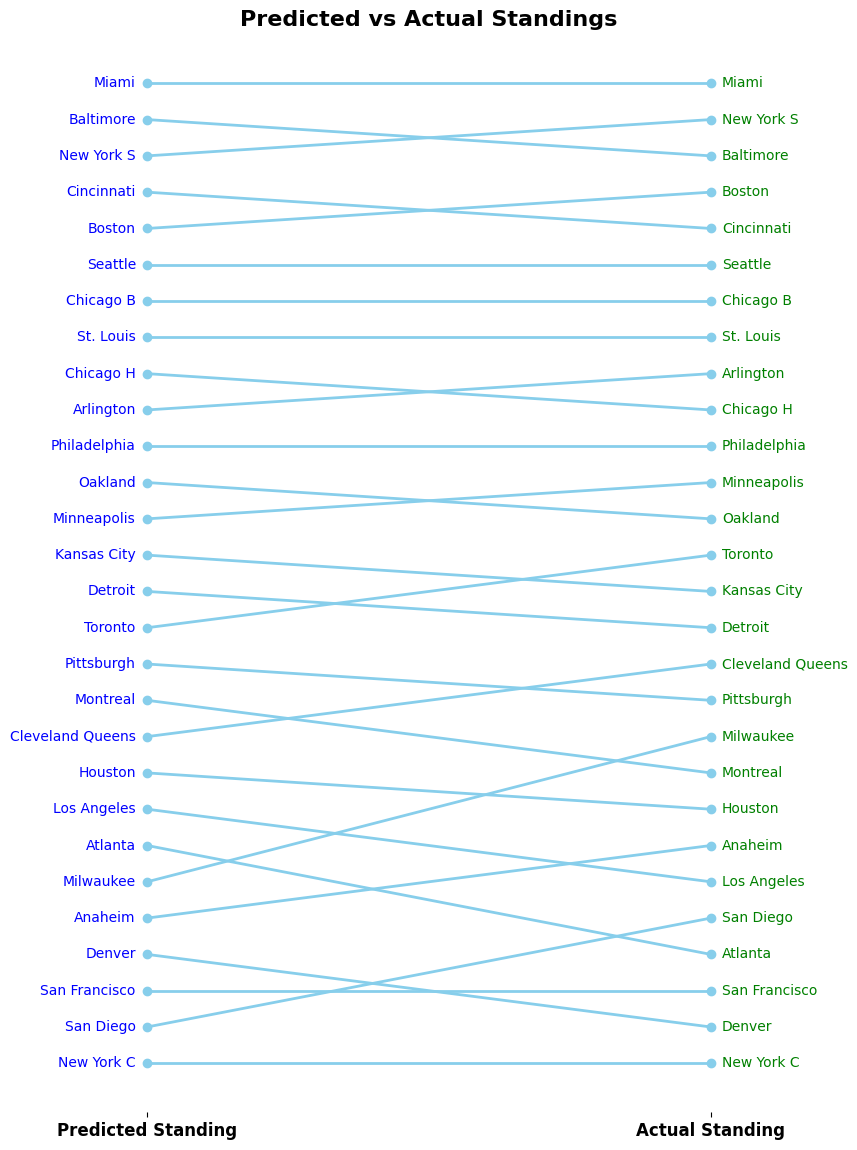

In [32]:
# Slope Chart
plt.figure(figsize=(8, 14))

# Plot lines connecting predicted and actual positions
for i, row in comparison.iterrows():
    plt.plot([0, 1], [row['Pred_Position'], row['Actual_Position']], marker='o', color='skyblue', alpha=1, linewidth=2)
    plt.text(-0.02, row['Pred_Position'], row['TeamName'], ha='right', va='center', fontsize=10, color='blue')
    plt.text(1.02, row['Actual_Position'], row['TeamName'], ha='left', va='center', fontsize=10, color='green')

# Add titles and labels
plt.title('Predicted vs Actual Standings', fontsize=16, fontweight='bold')
plt.xlabel('')
plt.xticks([0, 1], ['Predicted Standing', 'Actual Standing'], fontsize=12, fontweight='bold')
plt.yticks([])

# Invert y-axis to have the top position at the top
plt.gca().invert_yaxis()

# Remove the spines (the box around the plot)
for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.show()


Above plot shows how the predicted standing compares with the actual standing. 